<a href="https://colab.research.google.com/github/iqbalhanif/Spatial-Machine-Learning/blob/main/Spatial_Machine_Learning_in_R_(Landslide_Classification_in_Banten).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##mount google drive agar bisa connect
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##cara agar bisa menggunakan R di colab
%load_ext rpy2.ipython

# 1. Membuat Data

In [ ]:
##download package yang tidak bisa di install dengan cara biasa (di colab)
!sudo apt-get update
!sudo apt-get install libgdal-dev libproj-dev 
!sudo apt-get update
!sudo apt install libgeos++dev

In [ ]:
##install dan load package yang sudah didownload tadi
%%R
install.packages("rgdal")
install.packages("rgeos")
library("rgdal") ##input/output file spatial
library("rgeos") ##maniplasi data spatial

In [ ]:
##install package2 yang bisa diinstall dengan cata biasa
%%R
install.packages("DMwR")
install.packages("caret")
install.packages("snow")
install.packages("maptools")
install.packages("randomForest")
install.packages("e1071")
library(devtools)
devtools:::install_github("gearslaboratory/gdalUtils")

In [ ]:
##load package yang sudah diinstall tadi
%%R
library(raster) ##bekerja dengan data raster
library(sp) ##bekerja dengan data vektor
library(dplyr) ##data processing/manipulation
library(DMwR) ##data processing/manipulation
library(caret) ##machine learning
library(snow) ##paralel computation untuk memproses komputasi
library(maptools) ##manipulasi data spasial
library(gdalUtils) ##manipulasi data spasial
library(randomForest) ##machine learning (random forest)
library(e1071)

In [ ]:
##create non-landslide data, karena data awal hanya ada landslide data (data tanah longsor)
##load slope yang kurang 10 derajat kemudian dianggap non-landslide
%%R
setwd("/content/drive/MyDrive/Machine Learning with R/Longsor R/")
slope <- raster("Slope.tif")
reclass_df <- c(0, 10, 1, 10, Inf, NA) ##membuat objek yang isinya adalah vektor, 0-10 nilainya 1, 10 - inf nilainya NA
reclass_m <- matrix(reclass_df, ncol = 3, byrow = TRUE)
reclass_m 

     [,1] [,2] [,3]
[1,]    0   10    1
[2,]   10  Inf   NA


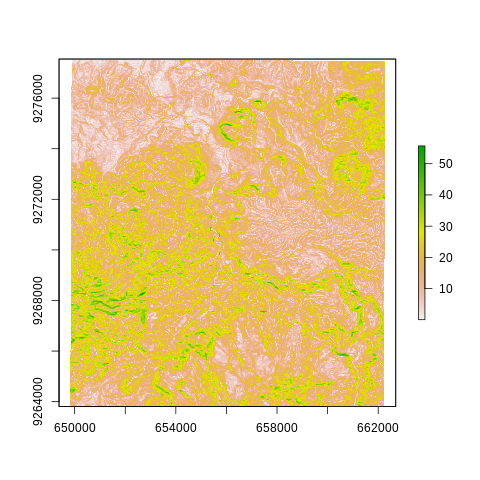

In [ ]:
##cek data slope
%%R
plot(slope)

In [ ]:
##classify data slope sesuai aturan tadi (matrix reclass)
##kemudian simpan datanya jadi poligon slope_no_ls
%%R
slope_classified <- reclassify(slope, reclass_m)
r.to.poly<-rasterToPolygons(slope_classified, dissolve = T) ##dissolve semuanya jadi satu fitur
writeOGR(r.to.poly, ".", "slope_no_ls2", driver="ESRI Shapefile")

In [ ]:
##cek perbedaan tipe data slope_classified dan r.to.poly
%%R
cat("slope_classified: ","\n")
print(slope_classified)
cat("r.to.poly: ","\n")
print(r.to.poly)

slope_classified:  
class      : RasterLayer 
dimensions : 1657, 1504, 2492128  (nrow, ncol, ncell)
resolution : 8.294963, 8.291468  (x, y)
extent     : 649800.7, 662276.4, 9263806, 9277545  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=48 +south +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0 
source     : memory
names      : Slope 
values     : 1, 1  (min, max)

r.to.poly:  
class       : SpatialPolygonsDataFrame 
features    : 1 
extent      : 649809, 662268.1, 9263815, 9277537  (xmin, xmax, ymin, ymax)
crs         : +proj=utm +zone=48 +south +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0 
variables   : 1
names       : Slope 
value       :     1 


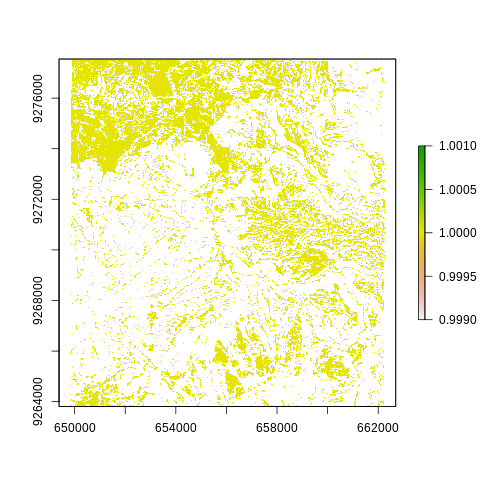

In [ ]:
##cek data slope_classified, yang 1 (hijau) memiliki kemiringan <= 10 derajat
%%R
plot(slope_classified)

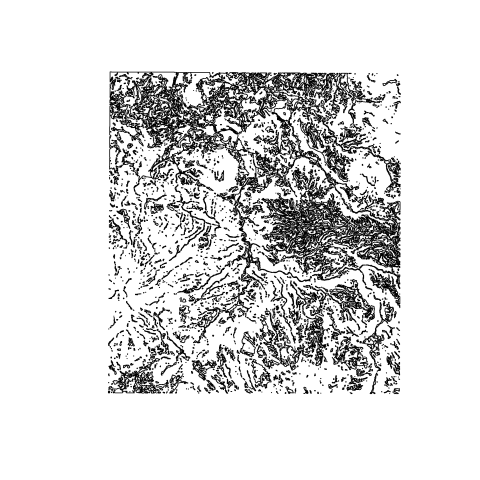

In [ ]:
##cek data r.to.poly
%%R
plot(r.to.poly)

In [ ]:
##read data polygon Landslides, kemudian transform
%%R
ls=readOGR("Titik longsor lebak.shp")
ls <- spTransform(ls, CRS = CRS(proj4string(slope)))
writeOGR(ls, ".", "ls", driver="ESRI Shapefile")
ls

OGR data source with driver: ESRI Shapefile 
Source: "/content/drive/MyDrive/Machine Learning with R/Longsor R/Titik longsor lebak.shp", layer: "Titik longsor lebak"
with 40 features
It has 5 fields
class       : SpatialPointsDataFrame 
features    : 40 
extent      : 653868, 656442, 9267675, 9275022  (xmin, xmax, ymin, ymax)
crs         : +proj=utm +zone=48 +south +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0 
variables   : 5
names       : objectid, no,           titik,    latitude,    longitude 
min values  :        1,  9, Titik Longsor 1, -6.62326002, 106.39199829 
max values  :       40, 48, Titik Longsor 9, -6.55684996, 106.41500092 


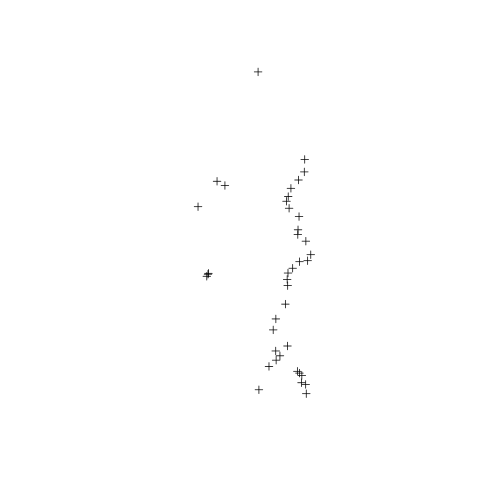

In [ ]:
##plot lokasi longsor/landslides
%%R
plot(ls)

In [ ]:
##membuat data no landslide, lokasi dimana tidak ada longsor
%%R
no.ls<-spsample(r.to.poly,n=100,"random") ##enambahkan titik2 random berdasarkan kemiringan <10
no.ls <- spTransform(no.ls, CRS = CRS(proj4string(slope)))
no.ls.spdf <- as(no.ls,"SpatialPointsDataFrame") ##diubah ke spatial point dataframe agar bisa disimpan ke csv
df <- as.data.frame(no.ls.spdf@coords)
write.csv(df, file="no_ls.csv")

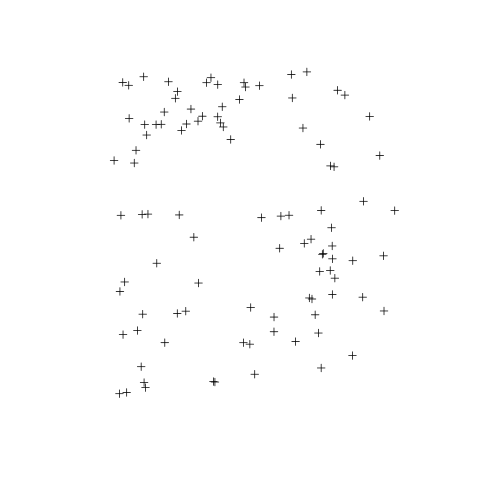

In [ ]:
##plot lokasi no landslides
%%R
plot(no.ls)

In [ ]:
#create merged raster sebagai data x
#load raster
%%R
slope <- raster("Slope.tif")
ndvi <- raster("ndvi.tif")
landcover <- raster("Landuse2.tif")
elevation <- raster("elevasi2.tif")
curvature <- raster("Curvature.tif")
#merged raster
a <- c('Slope.tif', 'ndvi.tif', 'Landuse2.tif', 'elevasi2.tif','Curvature.tif')
e <- extent(slope)
template <- raster(e) ##raster yang ukurannya mengikuti extent(slope)
proj4string(template) <- CRS('+init=epsg:23037')  ##assign proyeksi/CRS
writeRaster(template, file="merged.tif", format="GTiff", overwrite=TRUE)
mosaic_rasters(gdalfile=a,dst_dataset="merged.tif",of="GTiff",separate=TRUE)

[1] "/tmp/RtmpEHjC5X/file39cc6cf80.vrt"        
[2] "/tmp/RtmpEHjC5X/file394dff78a2_warped.vrt"
[3] "/tmp/RtmpEHjC5X/file39e2bb1d5.vrt"        
[4] "/tmp/RtmpEHjC5X/file396363782d.vrt"       
[5] "/tmp/RtmpEHjC5X/file3922b832d4.vrt"       
NULL


# 2. Modeling Data

In [ ]:
## Load data
%%R
rasstack=stack("merged.tif") ##data X
point=readOGR("raw.shp") ##data Y, 1 = no ls, 2 = ls
rasvalue=extract(rasstack,point)
combined=cbind(point,rasvalue)
head(combined)
colnames(combined@data)[4] = "B1"
colnames(combined@data)[5] = "B2"
colnames(combined@data)[6] = "B3"
colnames(combined@data)[7] = "B4"
colnames(combined@data)[8] = "B5"
head(combined)

OGR data source with driver: ESRI Shapefile 
Source: "/content/drive/MyDrive/Machine Learning with R/Longsor R/raw.shp", layer: "raw"
with 80 features
It has 3 fields
Integer64 fields read as strings:  class 
  class        X       Y        B1        B2 B3  B4         B5
1     2 656046.9 9264865  4.056852 0.2666265  6 899  0.4457458
2     2 655716.6 9267448  4.267015 0.3241163  6 387 -0.6214273
3     2 657688.0 9265656  8.044212 0.3563978  6 781  0.4416653
4     2 658646.3 9274004 12.153118 0.4601895  6 348  1.0609636
5     2 654822.5 9272301  7.351693 0.4488541  2 313  0.9624560
6     2 660243.3 9267659 13.313751 0.4566752  4 638  1.1431494


In [ ]:
##cek jumlah data per kelas/label
%%R
print(dim(combined))
combined@data %>%
  group_by(class) %>%
  summarise(
          count = n()
            )

[1] 80  8


R[write to console]: `summarise()` ungrouping output (override with `.groups` argument)



# A tibble: 2 x 2
  class count
  <chr> <int>
1 1        40
2 2        40


In [ ]:
##Data Cleansing dan transformation
%%R
val=combined@data
val <- na.omit(val) ##membuang data NA
val=val[sample(nrow(val)),] ##acak data agar merata saat train test split
val$class = as.factor(val$class) ##kolom class diubah menjadi faktor
print(dim(val))
head(val)

[1] 80  8
   class        X       Y        B1        B2 B3  B4          B5
58     1 654095.0 9270403 19.307873 0.3171007  6 548 -0.36333826
70     1 655488.0 9268298 24.798353 0.4204402  2 355 -0.51892793
23     2 651820.7 9265484  5.962862 0.3234136  6 701 -0.06413417
62     1 655910.0 9268764 10.793911 0.3212096  2 324  0.47559524
26     2 658811.1 9276437  8.853971 0.4765843  3 250  0.86306143
31     2 654745.7 9275947  8.866662 0.3021709  3 179  0.53686863


In [ ]:
## Train-tes split dengan proporsi 80%-20%
%%R
N_FILES=80
SPLT=0.7 #70% train
b = floor(SPLT*N_FILES)
train = val[1:b,]
test = val[(b+1):N_FILES,]
cat("train = ", dim(train), "\n")
cat("test = ", dim(test), "\n")

train =  56 8 
test =  24 8 


In [ ]:
## Modeling dengan data train
%%R
modFit_rf <- caret::train(class ~ B1+B2+B3+B4+B5, method = "rf", data=train)
modFit_rf

Random Forest 

56 samples
 5 predictor
 2 classes: '1', '2' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 56, 56, 56, 56, 56, 56, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  2     0.9003989  0.8006095
  3     0.8887122  0.7770802
  5     0.8617998  0.7232956

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.


In [ ]:
##validasi dengan data test
%%R
validation_result<-predict(modFit_rf,newdata=test)
result_comparison<-cbind(as.numeric(as.character(validation_result)),test[,1])
preds<-result_comparison[,1]
y<-result_comparison[,2]
confmat <- confusionMatrix(as.factor(y),as.factor(preds), positive='2')
confmat

Confusion Matrix and Statistics

          Reference
Prediction  1  2
         1 13  2
         2  1  8
                                          
               Accuracy : 0.875           
                 95% CI : (0.6764, 0.9734)
    No Information Rate : 0.5833          
    P-Value [Acc > NIR] : 0.002161        
                                          
                  Kappa : 0.7391          
                                          
 Mcnemar's Test P-Value : 1.000000        
                                          
            Sensitivity : 0.8000          
            Specificity : 0.9286          
         Pos Pred Value : 0.8889          
         Neg Pred Value : 0.8667          
             Prevalence : 0.4167          
         Detection Rate : 0.3333          
   Detection Prevalence : 0.3750          
      Balanced Accuracy : 0.8643          
                                          
       'Positive' Class : 2               
                                    

R[write to console]: Setting direction: controls < cases




Call:
roc.default(response = preds, predictor = y, levels = c("1",     "2"))

Data: y in 14 controls (preds 1) < 10 cases (preds 2).
Area under the curve: 0.8643


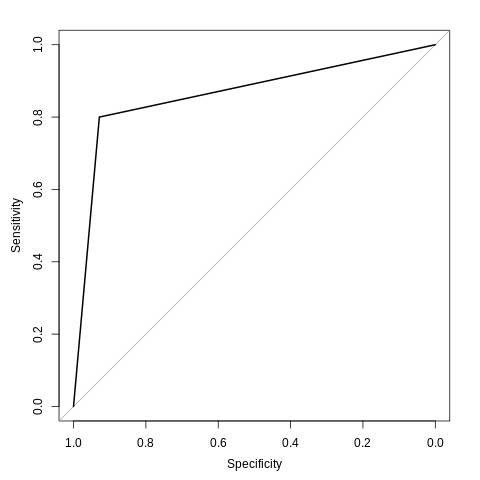

In [ ]:
##Kurva ROC
%%R
library(pROC)
kurva_roc<-roc(preds, y, levels=c("1", "2"))
print(kurva_roc)
plot(kurva_roc)

In [ ]:
##mempersiapkan data untuk prediksi
%%R
img_subset <- brick("merged.tif")
names(img_subset) <- c(paste0("B", 1:5, coll = ""))

R[write to console]: 2 cores detected, using 1



           used  (Mb) gc trigger  (Mb)  max used   (Mb)
Ncells  4100994 219.1   10549099 563.4 162166278 8660.7
Vcells 11599522  88.5   36550813 278.9 181466507 1384.5


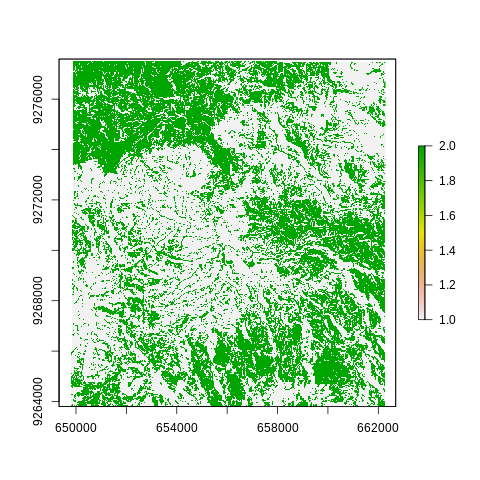

In [ ]:
##melakukan prediksi (1= no ls, 2 = ls)
%%R
#image prediction and write image
beginCluster()
preds_rf <- clusterR(img_subset, raster::predict, args = list(model = modFit_rf))
endCluster()
plot(preds_rf)
writeRaster(preds_rf, "rf_result_ls_pred", format = "GTiff", overwrite=TRUE)
gc()